
# 📘 M3.4 Pandas 進階數據合併與連接技術

本教學將深入探討 Pandas 中數據合併(Merge)與連接(Join)的進階技術，超越基本操作以應對複雜的數據整合場景。
我們將學習如何處理複雜的數據關係、優化大型數據集的合併操作，以及應用這些技術解決實際業務問題。


## 🎯 教學目標

- 🔍 掌握複雜數據合併策略與多種連接方式的深入應用
- 🔄 學習驗證與診斷合併結果的技術，確保數據完整性
- 📊 理解大數據集合併的性能優化方法
- 🧮 探索進階合併方式，如條件合併、階層化數據連接等
- 🛠️ 運用合併技術解決複雜業務場景的數據整合問題


## 🧰 1. 環境設置

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import wraps

# 設置中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設置中文字型為微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 設置顯示選項
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 100)
pd.set_option('display.precision', 2)

# 計時裝飾器用於性能測試
def timing_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 執行時間: {(end_time - start_time):.6f} 秒")
        return result
    return wrapper


## 📊 2. 創建複雜的示例數據集

In [113]:
# 創建更複雜的銷售數據環境
np.random.seed(42)

# 1. 客戶數據
customers = pd.DataFrame({
    'customer_id': range(1, 101),
    'customer_name': [f'Customer_{i}' for i in range(1, 101)],
    'customer_segment': np.random.choice(['Premium', 'Standard', 'Basic'], 100),
    'signup_date': pd.date_range(start='2020-01-01', periods=100),
    'region_id': np.random.randint(1, 6, 100)
})

# 2. 區域數據
regions = pd.DataFrame({
    'region_id': range(1, 6),
    'region_name': ['North', 'South', 'East', 'West', 'Central'],
    'country': ['USA', 'Canada', 'UK', 'Germany', 'France'],
    'regional_manager': ['John Smith', 'Emily Johnson', 'David Brown', 'Sarah Wilson', 'Michael Lee']
})

# 3. 產品數據
products = pd.DataFrame({
    'product_id': range(101, 121),
    'product_name': [f'Product_{i}' for i in range(101, 121)],
    'category_id': np.random.randint(1, 5, 20),
    'unit_price': np.random.uniform(10, 100, 20).round(2),
    'supplier_id': np.random.randint(1, 11, 20)
})

# 4. 類別數據
categories = pd.DataFrame({
    'category_id': range(1, 5),
    'category_name': ['Electronics', 'Clothing', 'Home Goods', 'Food & Beverage'],
    'category_manager': ['Alice Johnson', 'Bob Williams', 'Carol Davis', 'Dan Miller']
})

# 5. 供應商數據
suppliers = pd.DataFrame({
    'supplier_id': range(1, 11),
    'supplier_name': [f'Supplier_{i}' for i in range(1, 11)],
    'supplier_country': np.random.choice(['USA', 'China', 'India', 'Germany', 'Japan'], 10),
    'lead_time_days': np.random.randint(5, 30, 10)
})

# 6. 訂單數據 (將創建1000筆訂單)
order_headers = pd.DataFrame({
    'order_id': range(1001, 2001),
    'customer_id': np.random.choice(customers['customer_id'], 1000),
    'order_date': pd.date_range(start='2023-01-01', periods=1000),
    'status': np.random.choice(['Completed', 'Shipped', 'Processing', 'Cancelled'], 1000, 
                              p=[0.7, 0.15, 0.1, 0.05]),
    'sales_rep_id': np.random.randint(1, 21, 1000)
})

# 7. 訂單詳情 (每個訂單平均2-5個產品項目，共約3000個訂單項目)
num_order_items = 3000
order_items = pd.DataFrame({
    'order_item_id': range(1, num_order_items + 1),
    'order_id': np.random.choice(order_headers['order_id'], num_order_items),
    'product_id': np.random.choice(products['product_id'], num_order_items),
    'quantity': np.random.randint(1, 10, num_order_items),
    'discount': np.random.choice([0, 0.05, 0.1, 0.15, 0.2], num_order_items)
})

# 8. 銷售代表數據
sales_reps = pd.DataFrame({
    'sales_rep_id': range(1, 21),
    'sales_rep_name': [f'Rep_{i}' for i in range(1, 21)],
    'region_id': np.random.randint(1, 6, 20),
    'hire_date': pd.date_range(start='2018-01-01', periods=20)
})

# 9. 支付數據 (只有已完成的訂單有支付記錄)
completed_orders = order_headers[order_headers['status'] == 'Completed']['order_id']
payments = pd.DataFrame({
    'payment_id': range(1, len(completed_orders) + 1),
    'order_id': completed_orders.values,
    'payment_date': pd.date_range(start='2023-01-05', periods=len(completed_orders)),
    'payment_method': np.random.choice(['Credit Card', 'PayPal', 'Bank Transfer', 'Cash'], len(completed_orders)),
    'amount': np.random.uniform(50, 500, len(completed_orders)).round(2)
})

print("創建了以下數據表:")
print(f"1. 客戶 (Customers): {customers.shape[0]} 行 x {customers.shape[1]} 列")
print(f"2. 區域 (Regions): {regions.shape[0]} 行 x {regions.shape[1]} 列")
print(f"3. 產品 (Products): {products.shape[0]} 行 x {products.shape[1]} 列")
print(f"4. 類別 (Categories): {categories.shape[0]} 行 x {categories.shape[1]} 列")
print(f"5. 供應商 (Suppliers): {suppliers.shape[0]} 行 x {suppliers.shape[1]} 列")
print(f"6. 訂單標頭 (Order Headers): {order_headers.shape[0]} 行 x {order_headers.shape[1]} 列")
print(f"7. 訂單項目 (Order Items): {order_items.shape[0]} 行 x {order_items.shape[1]} 列")
print(f"8. 銷售代表 (Sales Reps): {sales_reps.shape[0]} 行 x {sales_reps.shape[1]} 列")
print(f"9. 支付 (Payments): {payments.shape[0]} 行 x {payments.shape[1]} 列")

# 查看訂單標頭與項目數據示例
print("\n訂單標頭示例:")
print(order_headers.head(3))
print("\n訂單項目示例:")
print(order_items.head(3))

創建了以下數據表:
1. 客戶 (Customers): 100 行 x 5 列
2. 區域 (Regions): 5 行 x 4 列
3. 產品 (Products): 20 行 x 5 列
4. 類別 (Categories): 4 行 x 3 列
5. 供應商 (Suppliers): 10 行 x 4 列
6. 訂單標頭 (Order Headers): 1000 行 x 5 列
7. 訂單項目 (Order Items): 3000 行 x 5 列
8. 銷售代表 (Sales Reps): 20 行 x 4 列
9. 支付 (Payments): 709 行 x 5 列

訂單標頭示例:
   order_id  customer_id order_date     status  sales_rep_id
0      1001          100 2023-01-01  Completed            12
1      1002           33 2023-01-02  Completed             9
2      1003           68 2023-01-03  Completed            15

訂單項目示例:
   order_item_id  order_id  product_id  quantity  discount
0              1      1822         119         1       0.0
1              2      1952         106         8       0.1
2              3      1982         113         1       0.1



## 📊 3. 複雜數據關係處理


### 3.1 多表關聯分析

In [114]:
# 建立訂單的完整視圖（訂單、客戶、產品、類別、銷售代表）
@timing_decorator
def create_order_full_view():
    # 第一步：合併訂單與訂單項目
    order_with_items = pd.merge(
        order_headers,
        order_items,
        on='order_id',
        how='inner'
    )
    
    # 第二步：加入產品信息
    order_with_products = pd.merge(
        order_with_items,
        products,
        on='product_id',
        how='inner'
    )
    
    # 第三步：加入類別信息
    order_with_categories = pd.merge(
        order_with_products,
        categories,
        on='category_id',
        how='inner'
    )
    
    # 第四步：加入客戶信息
    order_with_customers = pd.merge(
        order_with_categories,
        customers,
        on='customer_id',
        how='inner'
    )
    
    # 第五步：加入銷售代表信息
    full_order_view = pd.merge(
        order_with_customers,
        sales_reps,
        on='sales_rep_id',
        how='inner'
    )
    
    # 計算訂單項目金額
    full_order_view['item_price'] = full_order_view['unit_price'] * full_order_view['quantity'] * (1 - full_order_view['discount'])
    
    return full_order_view

# 創建完整訂單視圖
full_orders = create_order_full_view()

print(f"完整訂單視圖維度: {full_orders.shape}")
print("包含的列:")
print(full_orders.columns.tolist())
print("\n前3筆數據:")
print(full_orders.head(3))



create_order_full_view 執行時間: 0.006015 秒
完整訂單視圖維度: (3000, 23)
包含的列:
['order_id', 'customer_id', 'order_date', 'status', 'sales_rep_id', 'order_item_id', 'product_id', 'quantity', 'discount', 'product_name', 'category_id', 'unit_price', 'supplier_id', 'category_name', 'category_manager', 'customer_name', 'customer_segment', 'signup_date', 'region_id_x', 'sales_rep_name', 'region_id_y', 'hire_date', 'item_price']

前3筆數據:
   order_id  customer_id order_date     status  sales_rep_id  order_item_id  ...  signup_date  \
0      1001          100 2023-01-01  Completed            12            580  ...   2020-04-09   
1      1001          100 2023-01-01  Completed            12           1978  ...   2020-04-09   
2      1002           33 2023-01-02  Completed             9           1936  ...   2020-02-02   

   region_id_x  sales_rep_name region_id_y  hire_date  item_price  
0            1          Rep_12           3 2018-01-12      275.34  
1            1          Rep_12           3 2018-01-12


### 3.2 理解合併後數據量變化

合併過程中的數據量變化分析:
      合併步驟  記錄數量 變化率                   說明
0   原始訂單項目  3000  基準                 基準數量
1  訂單+訂單項目  3000  基準  1:1 關係，每個訂單項目對應一個訂單
2     + 產品  3000  基準  1:1 關係，每個訂單項目對應一個產品
3     + 類別  3000  基準    1:1 關係，每個產品對應一個類別
4     + 客戶  3000  基準    1:1 關係，每個訂單對應一個客戶
5   + 銷售代表  3000  基準  1:1 關係，每個訂單對應一個銷售代表


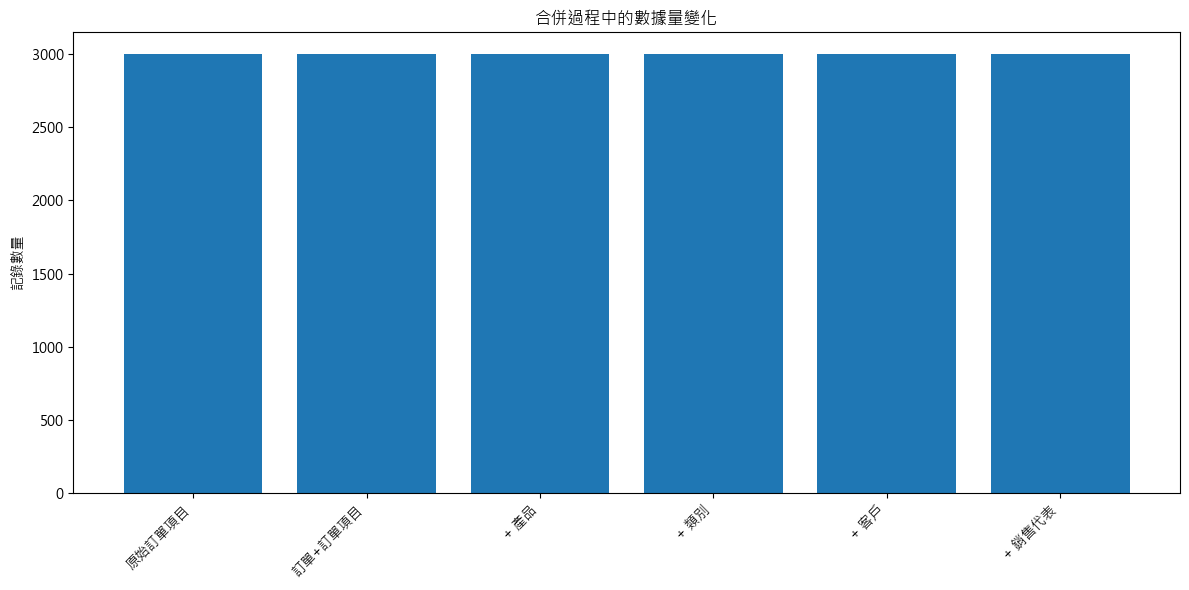

In [115]:
# 分析逐步合併過程中的數據量變化
def analyze_merge_cardinality():
    # 記錄每一步合併的數據量
    steps = []
    
    # 原始訂單項目數量
    steps.append(("原始訂單項目", len(order_items)))
    
    # 步驟 1: 訂單標頭 + 訂單項目
    step1 = pd.merge(order_items, order_headers, on='order_id')
    steps.append(("訂單+訂單項目", len(step1)))
    
    # 步驟 2: + 產品
    step2 = pd.merge(step1, products, on='product_id')
    steps.append(("+ 產品", len(step2)))
    
    # 步驟 3: + 類別
    step3 = pd.merge(step2, categories, on='category_id')
    steps.append(("+ 類別", len(step3)))
    
    # 步驟 4: + 客戶
    step4 = pd.merge(step3, customers, on='customer_id')
    steps.append(("+ 客戶", len(step4)))
    
    # 步驟 5: + 銷售代表
    step5 = pd.merge(step4, sales_reps, on='sales_rep_id')
    steps.append(("+ 銷售代表", len(step5)))
    
    # 創建結果 DataFrame
    cardinality_df = pd.DataFrame(steps, columns=["合併步驟", "記錄數量"])
    cardinality_df["變化率"] = cardinality_df["記錄數量"].pct_change().fillna(0) * 100
    cardinality_df["變化率"] = cardinality_df["變化率"].map(lambda x: f"{x:.2f}%" if x != 0 else "基準")
    cardinality_df["說明"] = [
        "基準數量",
        "1:1 關係，每個訂單項目對應一個訂單",
        "1:1 關係，每個訂單項目對應一個產品",
        "1:1 關係，每個產品對應一個類別",
        "1:1 關係，每個訂單對應一個客戶",
        "1:1 關係，每個訂單對應一個銷售代表"
    ]
    
    return cardinality_df

cardinality_analysis = analyze_merge_cardinality()
print("合併過程中的數據量變化分析:")
print(cardinality_analysis)

# 可視化數據量變化
plt.figure(figsize=(12, 6))
plt.bar(cardinality_analysis["合併步驟"], cardinality_analysis["記錄數量"])
plt.title("合併過程中的數據量變化")
plt.ylabel("記錄數量")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 3.3 避免笛卡爾積問題

In [116]:
# 示範笛卡爾積問題
def demonstrate_cartesian_problem():
    # 創建簡單示例數據
    df1 = pd.DataFrame({
        'key': [1, 2, 3],
        'value_a': ['a1', 'a2', 'a3']
    })
    
    df2 = pd.DataFrame({
        'key': [1, 1, 1, 2, 2, 3],  # 注意這裡有重複的鍵
        'value_b': ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
    })
    
    print("DataFrame 1:")
    print(df1)
    print("\nDataFrame 2 (包含重複的鍵):")
    print(df2)
    
    # 執行內連接
    merged = pd.merge(df1, df2, on='key')
    print("\n合併結果 (產生笛卡爾積):")
    print(merged)
    print(f"合併前: df1有{len(df1)}行, df2有{len(df2)}行")
    print(f"合併後: {len(merged)}行")
    
    # 分析連接基數
    key_counts_df1 = df1['key'].value_counts().reset_index()
    key_counts_df1.columns = ['key', 'count_df1']
    
    key_counts_df2 = df2['key'].value_counts().reset_index()
    key_counts_df2.columns = ['key', 'count_df2']
    
    key_analysis = pd.merge(key_counts_df1, key_counts_df2, on='key', how='outer').fillna(0)
    key_analysis['expected_rows'] = key_analysis['count_df1'] * key_analysis['count_df2']
    
    print("\n鍵分佈分析:")
    print(key_analysis)
    print(f"預期的合併行數: {key_analysis['expected_rows'].sum()}")
    
    return df1, df2, merged

# 執行演示
df1, df2, cartesian_result = demonstrate_cartesian_problem()

# 提供避免笛卡爾積的方法
print("\n避免笛卡爾積的方法:")
print("1. 在合併前檢查並刪除重複的鍵值:")
df2_unique = df2.drop_duplicates(subset=['key'])
safe_merge = pd.merge(df1, df2_unique, on='key')
print(f"   去除重複後合併: {len(safe_merge)}行")

print("2. 使用 merge 前的驗證函數:")
def validate_merge_keys(df1, df2, key):
    df1_key_counts = df1[key].value_counts()
    df2_key_counts = df2[key].value_counts()
    
    potential_explosion = 0
    for k in df1_key_counts.index:
        if k in df2_key_counts.index:
            potential_explosion += df1_key_counts[k] * df2_key_counts[k]
    
    print(f"   合併前: df1有{len(df1)}行, df2有{len(df2)}行")
    print(f"   潛在合併結果: {potential_explosion}行")
    
    explosion_factor = potential_explosion / (len(df1) + len(df2))
    print(f"   爆炸因子: {explosion_factor:.2f}x")
    
    if explosion_factor > 2:
        print("   警告: 可能發生大量數據膨脹!")
        return False
    return True

print("\n驗證合併鍵:")
is_safe = validate_merge_keys(df1, df2, 'key')

DataFrame 1:
   key value_a
0    1      a1
1    2      a2
2    3      a3

DataFrame 2 (包含重複的鍵):
   key value_b
0    1      b1
1    1      b2
2    1      b3
3    2      b4
4    2      b5
5    3      b6

合併結果 (產生笛卡爾積):
   key value_a value_b
0    1      a1      b1
1    1      a1      b2
2    1      a1      b3
3    2      a2      b4
4    2      a2      b5
5    3      a3      b6
合併前: df1有3行, df2有6行
合併後: 6行

鍵分佈分析:
   key  count_df1  count_df2  expected_rows
0    1          1          3              3
1    2          1          2              2
2    3          1          1              1
預期的合併行數: 6

避免笛卡爾積的方法:
1. 在合併前檢查並刪除重複的鍵值:
   去除重複後合併: 3行
2. 使用 merge 前的驗證函數:

驗證合併鍵:
   合併前: df1有3行, df2有6行
   潛在合併結果: 6行
   爆炸因子: 0.67x



## 📊 4. 合併驗證與診斷技術


### 4.1 驗證合併操作的完整性

In [117]:
# 檢查合併是否遺漏數據
def check_merge_completeness(left_df, right_df, merged_df, left_on, right_on=None, how='inner'):
    if right_on is None:
        right_on = left_on
    
    # 計算預期的結果大小
    if how == 'inner':
        left_keys = set(left_df[left_on])
        right_keys = set(right_df[right_on])
        common_keys = left_keys.intersection(right_keys)
        
        left_matched = left_df[left_df[left_on].isin(common_keys)]
        right_matched = right_df[right_df[right_on].isin(common_keys)]
        
        expected_rows = len(left_matched) if len(left_matched) <= len(right_matched) else len(right_matched)
        if len(left_matched) > 0 and len(right_matched) > 0:
            # 對於多對多關係，計算上限
            left_counts = left_matched[left_on].value_counts()
            right_counts = right_matched[right_on].value_counts()
            max_rows = sum(left_counts[k] * right_counts[k] for k in common_keys if k in left_counts and k in right_counts)
            expected_rows = max_rows
    
    elif how == 'left':
        expected_rows = len(left_df)
    elif how == 'right':
        expected_rows = len(right_df)
    elif how == 'outer':
        # 外連接可能比較複雜，這裡簡化處理
        expected_rows = len(left_df) + len(right_df) - len(set(left_df[left_on]).intersection(set(right_df[right_on])))
    
    actual_rows = len(merged_df)
    
    print(f"合併完整性檢查 ({how} join):")
    print(f"左表行數: {len(left_df)}")
    print(f"右表行數: {len(right_df)}")
    print(f"合併結果行數: {actual_rows}")
    print(f"預期結果行數 (約): {expected_rows}")
    
    if how in ['left', 'right', 'outer']:
        # 檢查空值情況
        if how == 'left' or how == 'outer':
            null_count = merged_df[right_df.columns[0]].isna().sum()
            print(f"右表列中的空值數: {null_count} ({null_count/len(merged_df):.2%})")
        
        if how == 'right' or how == 'outer':
            null_count = merged_df[left_df.columns[0]].isna().sum()
            print(f"左表列中的空值數: {null_count} ({null_count/len(merged_df):.2%})")
    
    return {
        'left_rows': len(left_df),
        'right_rows': len(right_df),
        'merged_rows': actual_rows,
        'expected_rows': expected_rows,
        'match_rate': actual_rows / expected_rows if expected_rows > 0 else 0
    }

# 示範合併驗證
orders_sample = order_headers.sample(100, random_state=42)
customers_sample = customers.sample(50, random_state=42)

# 執行左連接
left_join = pd.merge(orders_sample, customers_sample, on='customer_id', how='left')

# 驗證合併結果
merge_stats = check_merge_completeness(orders_sample, customers_sample, left_join, 'customer_id', how='left')

合併完整性檢查 (left join):
左表行數: 100
右表行數: 50
合併結果行數: 100
預期結果行數 (約): 100
右表列中的空值數: 0 (0.00%)



### 4.2 合併後數據一致性驗證

In [118]:
# 合併後的數據一致性檢查
def validate_merge_consistency(original_df1, original_df2, merged_df, key):
    """檢查合併後的數據是否與原始數據集一致"""
    # 檢查鍵的唯一性
    print("檢查合併鍵的唯一性:")
    print(f"左表 '{key}' 唯一值數量: {original_df1[key].nunique()}")
    print(f"右表 '{key}' 唯一值數量: {original_df2[key].nunique()}")
    print(f"合併表 '{key}' 唯一值數量: {merged_df[key].nunique()}")
    
    # 檢查聚合指標是否保持一致
    print("\n檢查數值列的聚合指標:")
    
    # 選擇數值列
    numeric_cols1 = original_df1.select_dtypes(include=['number']).columns
    numeric_cols2 = original_df2.select_dtypes(include=['number']).columns
    
    # 排除合併鍵
    numeric_cols1 = [col for col in numeric_cols1 if col != key]
    numeric_cols2 = [col for col in numeric_cols2 if col != key]
    
    # 檢查左表的數值列
    for col in numeric_cols1[:2]:  # 僅檢查前兩列作為示例
        if col in merged_df.columns:
            orig_sum = original_df1[col].sum()
            merged_sum = merged_df[col].sum()
            
            print(f"列 '{col}' 總和 - 原始: {orig_sum}, 合併後: {merged_sum}, 差異: {abs(orig_sum - merged_sum)}")
    
    # 檢查右表的數值列
    for col in numeric_cols2[:2]:  # 僅檢查前兩列作為示例
        if col in merged_df.columns:
            orig_sum = original_df2[col].sum()
            merged_sum = merged_df[col].sum()
            
            print(f"列 '{col}' 總和 - 原始: {orig_sum}, 合併後: {merged_sum}, 差異: {abs(orig_sum - merged_sum)}")
    
    # 檢查每個合併鍵值的行數一致性
    print("\n檢查各鍵值的行數:")
    key_counts_orig1 = original_df1[key].value_counts().sort_index()
    key_counts_orig2 = original_df2[key].value_counts().sort_index()
    key_counts_merged = merged_df[key].value_counts().sort_index()
    
    # 取樣展示幾個鍵值
    sample_keys = sorted(list(set(key_counts_orig1.index) & set(key_counts_orig2.index)))[:3]
    
    for k in sample_keys:
        count1 = key_counts_orig1.get(k, 0)
        count2 = key_counts_orig2.get(k, 0)
        count_merged = key_counts_merged.get(k, 0)
        
        print(f"鍵值 {k}: 左表 {count1} 行, 右表 {count2} 行, 合併表 {count_merged} 行")
        
        # 如果是一對多或多對多關係，解釋預期行數
        if count1 > 1 or count2 > 1:
            expected = count1 * count2
            print(f"  預期行數: {count1} x {count2} = {expected}")
    
    return True

# 示範驗證
validate_merge_consistency(orders_sample, customers, left_join, 'customer_id')

檢查合併鍵的唯一性:
左表 'customer_id' 唯一值數量: 61
右表 'customer_id' 唯一值數量: 100
合併表 'customer_id' 唯一值數量: 61

檢查數值列的聚合指標:
列 'order_id' 總和 - 原始: 148978, 合併後: 148978, 差異: 0
列 'sales_rep_id' 總和 - 原始: 985, 合併後: 985, 差異: 0
列 'region_id' 總和 - 原始: 287, 合併後: 144.0, 差異: 143.0

檢查各鍵值的行數:
鍵值 1: 左表 1 行, 右表 1 行, 合併表 1 行
鍵值 6: 左表 1 行, 右表 1 行, 合併表 1 行
鍵值 9: 左表 1 行, 右表 1 行, 合併表 1 行


True


## 📊 5. 高性能合併技術


### 5.1 大數據集合併優化

In [119]:
# 創建較大的測試數據集
def create_large_test_data(size=1000000):
    """創建大型測試數據集用於性能測試"""
    np.random.seed(42)
    large_df1 = pd.DataFrame({
        'id': np.arange(size),
        'key': np.random.randint(0, size // 10, size),
        'value_a': np.random.randn(size)
    })
    
    large_df2 = pd.DataFrame({
        'key': np.random.randint(0, size // 10, size // 5),
        'value_b': np.random.randn(size // 5)
    })
    
    return large_df1, large_df2

# 較小規模測試 (為了演示，使用較小的數據集)
large_df1, large_df2 = create_large_test_data(size=100000)

print(f"大型數據集 1: {large_df1.shape}")
print(f"大型數據集 2: {large_df2.shape}")

# 性能測試：未優化的合併
@timing_decorator
def merge_unoptimized(df1, df2):
    return pd.merge(df1, df2, on='key')

# 性能測試：預排序優化
@timing_decorator
def merge_presorted(df1, df2):
    df1_sorted = df1.sort_values('key')
    df2_sorted = df2.sort_values('key')
    return pd.merge(df1_sorted, df2_sorted, on='key', sort=False)

# 性能測試：類別優化
@timing_decorator
def merge_category(df1, df2):
    df1_cat = df1.copy()
    df2_cat = df2.copy()
    df1_cat['key'] = df1_cat['key'].astype('category')
    df2_cat['key'] = df2_cat['key'].astype('category')
    return pd.merge(df1_cat, df2_cat, on='key')

# 性能測試：分塊處理
@timing_decorator
def merge_chunked(df1, df2, chunk_size=20000):
    result_chunks = []
    
    # 根據 chunk_size 分割第一個 DataFrame
    for i in range(0, len(df1), chunk_size):
        chunk = df1.iloc[i:i+chunk_size]
        # 合併每個塊與第二個 DataFrame
        merged_chunk = pd.merge(chunk, df2, on='key')
        result_chunks.append(merged_chunk)
    
    # 將所有塊連接成最終結果
    return pd.concat(result_chunks, ignore_index=True)

# 運行性能測試
print("\n性能測試結果:")
result1 = merge_unoptimized(large_df1, large_df2)
result2 = merge_presorted(large_df1, large_df2)
result3 = merge_category(large_df1, large_df2)
result4 = merge_chunked(large_df1, large_df2)

print(f"\n合併結果行數 (檢查結果一致性):")
print(f"未優化: {len(result1)}")
print(f"預排序: {len(result2)}")
print(f"類別化: {len(result3)}")
print(f"分塊處理: {len(result4)}")

大型數據集 1: (100000, 3)
大型數據集 2: (20000, 2)

性能測試結果:
merge_unoptimized 執行時間: 0.014056 秒
merge_presorted 執行時間: 0.019995 秒
merge_category 執行時間: 0.024013 秒
merge_chunked 執行時間: 0.013001 秒

合併結果行數 (檢查結果一致性):
未優化: 200206
預排序: 200206
類別化: 200206
分塊處理: 200206



### 5.2 使用 SQL 進行合併 (超大數據集)

merge_with_sql 執行時間: 0.420862 秒
SQL合併結果行數: 200206
merge_with_sql 執行時間: 0.040161 秒
merge_with_sql 執行時間: 0.192680 秒
merge_with_sql 執行時間: 0.407770 秒

不同規模數據集的合併性能比較:
     size  unoptimized  presorted   sql
0   10000     2.00e-03   1.00e-03  0.04
1   50000     6.00e-03   9.68e-03  0.19
2  100000     1.00e-02   1.56e-02  0.41


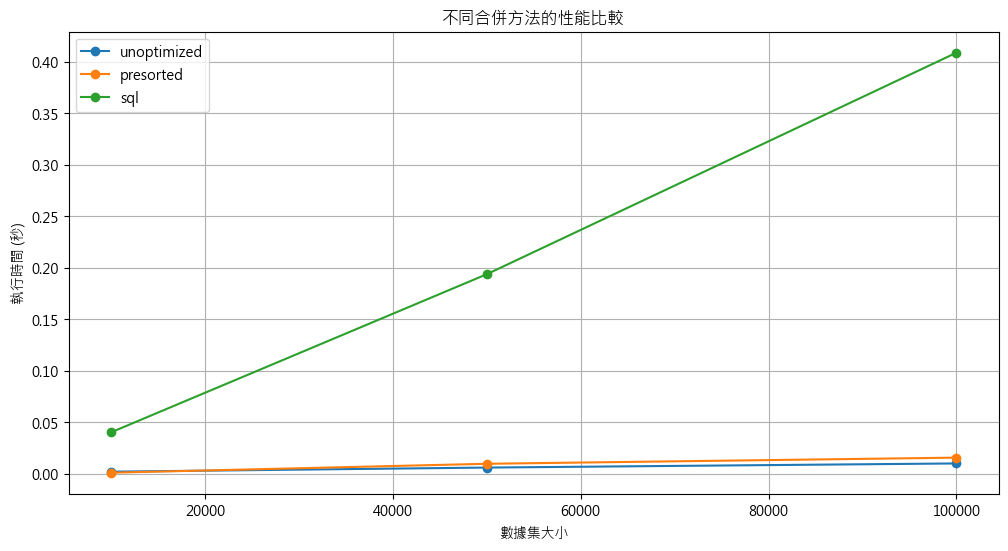

In [120]:
# 使用 SQLite 演示超大數據集合併
import sqlite3
from io import StringIO

@timing_decorator
def merge_with_sql(df1, df2, key):
    """使用 SQLite 進行大數據集合併"""
    # 創建臨時的內存數據庫連接
    conn = sqlite3.connect(':memory:')
    
    # 將 DataFrames 寫入 SQLite 表
    df1.to_sql('table1', conn, index=False, if_exists='replace')
    df2.to_sql('table2', conn, index=False, if_exists='replace')
    
    # 創建索引以加速合併
    conn.execute(f'CREATE INDEX idx_table1_{key} ON table1({key})')
    conn.execute(f'CREATE INDEX idx_table2_{key} ON table2({key})')
    
    # 編寫合併查詢
    query = f"""
    SELECT *
    FROM table1 t1
    INNER JOIN table2 t2 ON t1.{key} = t2.{key}
    """
    
    # 執行查詢並返回結果
    result = pd.read_sql_query(query, conn)
    
    # 關閉連接
    conn.close()
    
    return result

# 運行 SQL 合併測試
result_sql = merge_with_sql(large_df1, large_df2, 'key')
print(f"SQL合併結果行數: {len(result_sql)}")

# 比較合併方法的性能（不同規模的數據集）
def compare_merge_performance():
    results = []
    
    for size in [10000, 50000, 100000]:
        df1, df2 = create_large_test_data(size)
        
        # 測量未優化合併的時間
        start = time.time()
        pd.merge(df1, df2, on='key')
        time_unoptimized = time.time() - start
        
        # 測量預排序合併的時間
        start = time.time()
        df1_sorted = df1.sort_values('key')
        df2_sorted = df2.sort_values('key')
        pd.merge(df1_sorted, df2_sorted, on='key', sort=False)
        time_presorted = time.time() - start
        
        # 測量 SQL 合併的時間
        start = time.time()
        merge_with_sql(df1, df2, 'key')
        time_sql = time.time() - start
        
        results.append({
            'size': size,
            'unoptimized': time_unoptimized,
            'presorted': time_presorted,
            'sql': time_sql
        })
    
    return pd.DataFrame(results)

# 創建性能比較結果
performance_results = compare_merge_performance()
print("\n不同規模數據集的合併性能比較:")
print(performance_results)

# 可視化比較結果
plt.figure(figsize=(12, 6))
for method in ['unoptimized', 'presorted', 'sql']:
    plt.plot(performance_results['size'], performance_results[method], marker='o', label=method)
plt.title('不同合併方法的性能比較')
plt.xlabel('數據集大小')
plt.ylabel('執行時間 (秒)')
plt.legend()
plt.grid(True)
plt.show()


## 📊 6. 進階特殊合併技術


### 6.1 條件式合併

In [121]:
# 演示條件式合併
print("條件式合併 (Conditional Merge)")

# 創建價格表 (根據日期和產品的價格表)
price_history = pd.DataFrame({
    'product_id': np.repeat(np.arange(1, 6), 3),  # 5個產品，每個有3個不同的價格歷史
    'start_date': pd.to_datetime([
        '2023-01-01', '2023-04-01', '2023-07-01',  # 產品1
        '2023-01-01', '2023-03-01', '2023-06-01',  # 產品2
        '2023-01-01', '2023-05-01', '2023-08-01',  # 產品3
        '2023-01-01', '2023-02-01', '2023-09-01',  # 產品4
        '2023-01-01', '2023-06-01', '2023-10-01'   # 產品5
    ]),
    'end_date': pd.to_datetime([
        '2023-03-31', '2023-06-30', '2023-12-31',  # 產品1
        '2023-02-28', '2023-05-31', '2023-12-31',  # 產品2
        '2023-04-30', '2023-07-31', '2023-12-31',  # 產品3
        '2023-01-31', '2023-08-31', '2023-12-31',  # 產品4
        '2023-05-31', '2023-09-30', '2023-12-31'   # 產品5
    ]),
    'unit_price': [
        10.0, 12.0, 15.0,  # 產品1
        20.0, 22.0, 25.0,  # 產品2
        30.0, 28.0, 32.0,  # 產品3
        15.0, 18.0, 20.0,  # 產品4
        25.0, 30.0, 35.0   # 產品5
    ]
})

# 創建訂單資料，包含日期和產品
sample_orders = pd.DataFrame({
    'order_id': np.arange(1001, 1011),
    'product_id': np.random.randint(1, 6, 10),  # 隨機選擇產品
    'order_date': pd.to_datetime([
        '2023-02-15', '2023-03-20', '2023-04-10', '2023-05-05', '2023-06-15',
        '2023-07-20', '2023-08-10', '2023-09-05', '2023-10-15', '2023-11-20'
    ]),
    'quantity': np.random.randint(1, 10, 10)
})

print("價格歷史表:")
print(price_history.head())
print("\n訂單表:")
print(sample_orders)

# 條件式合併：根據日期範圍合併正確的價格
def merge_with_date_condition(orders, prices):
    """根據訂單日期在價格區間內進行條件式合併"""
    merged_data = []
    
    for _, order in orders.iterrows():
        order_date = order['order_date']
        product_id = order['product_id']
        
        # 找出適用的價格記錄
        applicable_price = prices[
            (prices['product_id'] == product_id) & 
            (prices['start_date'] <= order_date) & 
            (prices['end_date'] >= order_date)
        ]
        
        if not applicable_price.empty:
            # 將訂單與價格資訊合併
            order_dict = order.to_dict()
            order_dict.update({
                'unit_price': applicable_price.iloc[0]['unit_price'],
                'price_start_date': applicable_price.iloc[0]['start_date'],
                'price_end_date': applicable_price.iloc[0]['end_date']
            })
            merged_data.append(order_dict)
        else:
            # 沒有找到適用的價格
            order_dict = order.to_dict()
            order_dict.update({
                'unit_price': None,
                'price_start_date': None,
                'price_end_date': None
            })
            merged_data.append(order_dict)
    
    return pd.DataFrame(merged_data)

# 執行條件式合併
@timing_decorator
def perform_conditional_merge():
    return merge_with_date_condition(sample_orders, price_history)

conditional_merged = perform_conditional_merge()
print("\n條件式合併結果:")
print(conditional_merged[['order_id', 'product_id', 'order_date', 'quantity', 'unit_price']])
conditional_merged['total_amount'] = conditional_merged['quantity'] * conditional_merged['unit_price']
print("\n計算總金額後:")
print(conditional_merged[['order_id', 'product_id', 'quantity', 'unit_price', 'total_amount']])

條件式合併 (Conditional Merge)
價格歷史表:
   product_id start_date   end_date  unit_price
0           1 2023-01-01 2023-03-31        10.0
1           1 2023-04-01 2023-06-30        12.0
2           1 2023-07-01 2023-12-31        15.0
3           2 2023-01-01 2023-02-28        20.0
4           2 2023-03-01 2023-05-31        22.0

訂單表:
   order_id  product_id order_date  quantity
0      1001           2 2023-02-15         1
1      1002           4 2023-03-20         6
2      1003           5 2023-04-10         1
3      1004           3 2023-05-05         8
4      1005           1 2023-06-15         3
5      1006           1 2023-07-20         3
6      1007           5 2023-08-10         4
7      1008           4 2023-09-05         7
8      1009           2 2023-10-15         8
9      1010           1 2023-11-20         4
perform_conditional_merge 執行時間: 0.005002 秒

條件式合併結果:
   order_id  product_id order_date  quantity  unit_price
0      1001           2 2023-02-15         1        20.0
1      1002


### 6.2 使用 pd.merge_asof 進行近似合併

In [122]:
# 使用 merge_asof 進行近似合併 (類似資料庫中的近似連接)
print("近似合併 (Merge Asof)")

# 創建股票價格時間序列
np.random.seed(42)
stock_prices = pd.DataFrame({
    'timestamp': pd.date_range('2023-01-01', periods=10, freq='D'),
    'stock_price': np.random.randn(10).cumsum() + 100  # 模擬股票價格
})

# 創建訂單時間序列 (時間與股票價格不完全匹配)
trade_orders = pd.DataFrame({
    'timestamp': pd.to_datetime([
        '2023-01-01 12:30:00', '2023-01-02 09:15:00', 
        '2023-01-03 16:45:00', '2023-01-05 10:30:00',
        '2023-01-07 14:20:00', '2023-01-08 11:05:00'
    ]),
    'order_id': ['A001', 'A002', 'A003', 'A004', 'A005', 'A006'],
    'quantity': [100, 150, 200, 120, 180, 250]
})

print("股票價格時間序列:")
print(stock_prices)
print("\n訂單時間序列:")
print(trade_orders)

# 確保數據已排序 (merge_asof 要求按合併鍵排序)
stock_prices = stock_prices.sort_values('timestamp')
trade_orders = trade_orders.sort_values('timestamp')

# 使用 merge_asof 進行近似合併
# 這會找到每個訂單時間之前最近的股票價格
asof_merged = pd.merge_asof(
    trade_orders,
    stock_prices,
    on='timestamp',
    direction='backward'  # 使用之前最近的價格 (可改為 'forward' 或 'nearest')
)

print("\nmerge_asof 近似合併結果:")
print(asof_merged)

# 計算訂單值
asof_merged['order_value'] = asof_merged['quantity'] * asof_merged['stock_price']
print("\n計算訂單價值:")
print(asof_merged[['order_id', 'timestamp', 'quantity', 'stock_price', 'order_value']])

近似合併 (Merge Asof)
股票價格時間序列:
   timestamp  stock_price
0 2023-01-01       100.50
1 2023-01-02       100.36
2 2023-01-03       101.01
3 2023-01-04       102.53
4 2023-01-05       102.30
5 2023-01-06       102.06
6 2023-01-07       103.64
7 2023-01-08       104.41
8 2023-01-09       103.94
9 2023-01-10       104.48

訂單時間序列:
            timestamp order_id  quantity
0 2023-01-01 12:30:00     A001       100
1 2023-01-02 09:15:00     A002       150
2 2023-01-03 16:45:00     A003       200
3 2023-01-05 10:30:00     A004       120
4 2023-01-07 14:20:00     A005       180
5 2023-01-08 11:05:00     A006       250

merge_asof 近似合併結果:
            timestamp order_id  quantity  stock_price
0 2023-01-01 12:30:00     A001       100       100.50
1 2023-01-02 09:15:00     A002       150       100.36
2 2023-01-03 16:45:00     A003       200       101.01
3 2023-01-05 10:30:00     A004       120       102.30
4 2023-01-07 14:20:00     A005       180       103.64
5 2023-01-08 11:05:00     A006       250      


### 6.3 分層數據的合併 (階層式數據)

In [123]:
import pandas as pd

print("✅ 階層式數據合併與分析")

# 1. 組織結構資料（Org Hierarchy）
org_hierarchy = pd.DataFrame({
    'employee_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
    'name': ['John', 'Emma', 'Michael', 'Sophia', 'William', 'Olivia', 'James', 'Ava', 'Benjamin', 'Mia'],
    'department': ['Sales', 'IT', 'Marketing', 'Sales', 'Finance', 'IT', 'Marketing', 'Finance', 'Sales', 'IT'],
    'manager_id': [201, 201, 201, 201, 202, 202, 203, 205, 204, 206]  # New unique manager IDs
})

# 2. 員工業績資料（Performance）
performance = pd.DataFrame({
    'employee_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
    'sales': [150000, 0, 120000, 180000, 0, 0, 90000, 0, 200000, 0],
    'rating': [4.5, 4.8, 4.0, 4.7, 4.2, 4.9, 3.8, 4.1, 4.6, 4.3]
})

# 3. 員工 + 業績合併
employee_perf = pd.merge(org_hierarchy, performance, on='employee_id')

# 4. 合併經理資訊（不改名，保持語義清晰）
# Assuming manager details are in a separate DataFrame
managers = pd.DataFrame({
    'manager_id': [201, 202, 203, 204, 205, 206],
    'name': ['CEO', 'Emma', 'Michael', 'Sophia', 'William', 'Olivia'],
    'department': ['Executive', 'IT', 'Marketing', 'Sales', 'Finance', 'IT']
})

employee_with_mgr = pd.merge(
    employee_perf,
    managers,  # Use the managers DataFrame for manager details
    how='left',
    left_on='manager_id',     # 以員工的 manager_id 去對應
    right_on='manager_id',    # 對應經理的 manager_id
    suffixes=('', '_manager') # 自動區分欄位
)

print("組織結構資料（Org Hierarchy）")
print(org_hierarchy)

print("員工業績資料（Performance）")
print(performance)

print("經理資訊")
print(managers)

print("----" * 100)
# ✅ 顯示結果（員工與經理對應）
print("\n📌 員工與經理對應：")
print(employee_with_mgr[['employee_id', 'name', 'manager_id', 'name_manager', 'department_manager', 'sales', 'rating']])

# 5. 計算各經理的團隊績效（團隊總銷售與平均評分）
team_stats = employee_with_mgr.groupby('manager_id').agg(
    team_sales=('sales', 'sum'),
    team_avg_rating=('rating', 'mean')
).reset_index()

# 6. 經理本人資訊 + 團隊績效合併
manager_team_perf = pd.merge(
    managers,
    team_stats,
    on='manager_id',
    how='left'
)

# ✅ 顯示經理團隊績效彙總
print("\n📌 經理團隊績效彙總：")
print(manager_team_perf[['manager_id', 'name', 'team_sales', 'team_avg_rating']])

✅ 階層式數據合併與分析
組織結構資料（Org Hierarchy）
   employee_id      name department  manager_id
0          101      John      Sales         201
1          102      Emma         IT         201
2          103   Michael  Marketing         201
3          104    Sophia      Sales         201
4          105   William    Finance         202
5          106    Olivia         IT         202
6          107     James  Marketing         203
7          108       Ava    Finance         205
8          109  Benjamin      Sales         204
9          110       Mia         IT         206
員工業績資料（Performance）
   employee_id   sales  rating
0          101  150000     4.5
1          102       0     4.8
2          103  120000     4.0
3          104  180000     4.7
4          105       0     4.2
5          106       0     4.9
6          107   90000     3.8
7          108       0     4.1
8          109  200000     4.6
9          110       0     4.3
經理資訊
   manager_id     name department
0         201      CEO  Executive
1  


## 📊 7. 業務智能實際案例


### 7.1 銷售數據多維分析

In [136]:
full_orders.columns

Index(['order_id', 'customer_id', 'order_date', 'status', 'sales_rep_id', 'order_item_id',
       'product_id', 'quantity', 'discount', 'product_name', 'category_id', 'unit_price',
       'supplier_id', 'category_name', 'category_manager', 'customer_name', 'customer_segment',
       'signup_date', 'region_id_x', 'sales_rep_name', 'region_id_y', 'hire_date', 'item_price'],
      dtype='object')

銷售數據多維分析
類別銷售分析:
                類別       銷售總額  訂單數  客戶數  平均訂單金額      客單價
0         Clothing  232971.56  533   99  437.09  2353.25
1      Electronics  117556.52  350   98  335.88  1199.56
2  Food & Beverage  200876.31  572  100  351.18  2008.76
3       Home Goods  291368.79  598  100  487.24  2913.69

地區與銷售代表績效:
    地區    銷售代表      銷售總額  訂單數  客戶數   平均訂單金額
14   1   Rep_4  17242.86   18   13   957.94
6    1  Rep_15  16875.90   16   12  1054.74
3    1  Rep_12  16159.83   15   12  1077.32
55   3   Rep_5  16047.46   11   11  1458.86
4    1  Rep_13  15940.45   17   12   937.67
59   3   Rep_9  15703.91   17   13   923.76
66   4  Rep_15  14269.45   13   10  1097.65
58   3   Rep_8  13859.59   15   10   923.97
70   4  Rep_19  13506.80   16   13   844.17
0    1   Rep_1  13445.57   15   11   896.37

類別與客戶類型交叉分析:
customer_segment     Basic   Premium   Standard         總計  Basic %  Premium %  Standard %
category_name                                                                             
Clothi

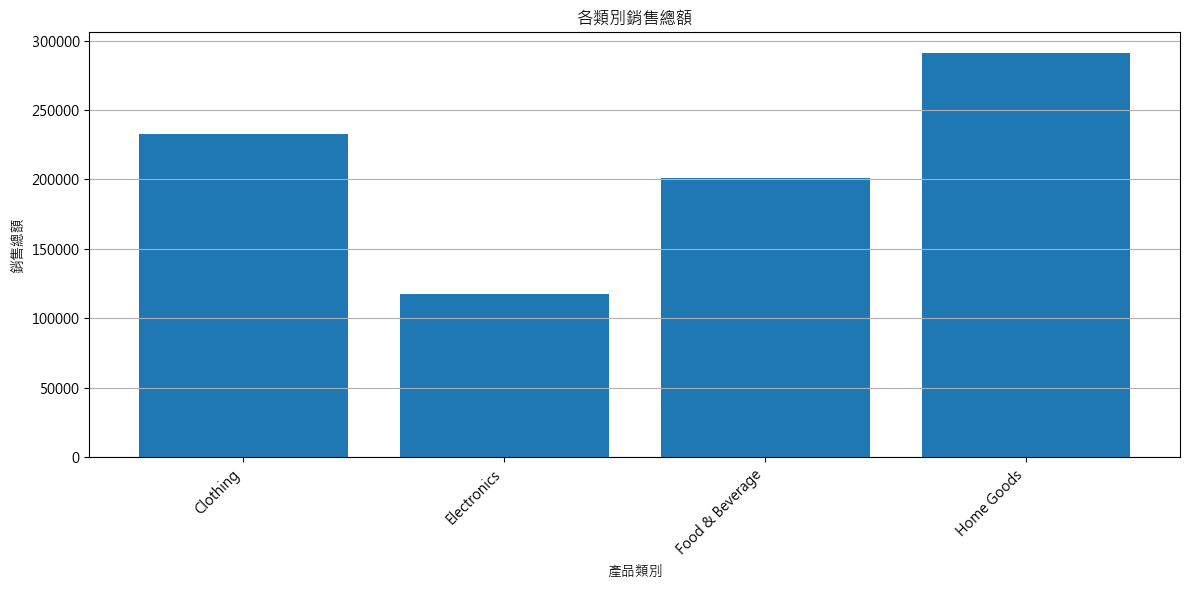

In [143]:
# 使用之前創建的完整訂單視圖進行多維銷售分析
print("銷售數據多維分析")

# 確保我們有完整訂單視圖數據
if 'full_orders' in locals():
    # 計算每個類別的銷售總計
    category_sales = full_orders.groupby('category_name').agg({
        'item_price': 'sum',
        'order_id': 'nunique',
        'customer_id': 'nunique'
    }).reset_index()
    
    category_sales.columns = ['類別', '銷售總額', '訂單數', '客戶數']
    category_sales['平均訂單金額'] = category_sales['銷售總額'] / category_sales['訂單數']
    category_sales['客單價'] = category_sales['銷售總額'] / category_sales['客戶數']
    
    print("類別銷售分析:")
    print(category_sales)
    
    # 按銷售代表和地區的銷售分析
    region_sales_rep = full_orders.groupby(['region_id_x', 'sales_rep_name']).agg({
        'item_price': 'sum',
        'order_id': 'nunique',
        'customer_id': 'nunique'
    }).reset_index()
    
    region_sales_rep.columns = ['地區', '銷售代表', '銷售總額', '訂單數', '客戶數']
    region_sales_rep['平均訂單金額'] = region_sales_rep['銷售總額'] / region_sales_rep['訂單數']
    
    print("\n地區與銷售代表績效:")
    print(region_sales_rep.sort_values('銷售總額', ascending=False).head(10))
    
    # 按類別和客戶類型的交叉分析
    category_customer_type = full_orders.groupby(['category_name', 'customer_segment']).agg({
        'item_price': 'sum'
    }).reset_index()
    
    # 數據透視表轉換
    category_customer_pivot = category_customer_type.pivot(
        index='category_name',
        columns='customer_segment',
        values='item_price'
    ).fillna(0)
    

    # 添加總計列
    category_customer_pivot['總計'] = category_customer_pivot.sum(axis=1)
    
    # 計算百分比
    for col in category_customer_pivot.columns:
        if col != '總計':
            category_customer_pivot[f'{col} %'] = category_customer_pivot[col] / category_customer_pivot['總計'] * 100
    
    print("\n類別與客戶類型交叉分析:")
    print(category_customer_pivot)
    
    # 可視化類別銷售
    plt.figure(figsize=(12, 6))
    plt.bar(category_sales['類別'], category_sales['銷售總額'])
    plt.title('各類別銷售總額')
    plt.xlabel('產品類別')
    plt.ylabel('銷售總額')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("尚未創建完整訂單視圖，請確保執行前面的代碼")


### 7.2 供應鏈分析

供應鏈分析
供應鏈數據:
  order_date  product_id  supplier_id  order_quantity  lead_time_days_x  defect_rate  ...  \
0 2023-01-01         107            7              34                28     9.11e-03  ...   
1 2023-01-02         120            3              63                 5     2.82e-02  ...   
2 2023-01-03         115            5              67                 4     4.20e-02  ...   
3 2023-01-04         111            1              76                 3     4.46e-03  ...   
4 2023-01-05         108           10              55                19     2.68e-02  ...   

  supplier_country lead_time_days_y  product_name category_id    category_name category_manager  
0          Germany               26   Product_107           2         Clothing     Bob Williams  
1              USA               22   Product_120           4  Food & Beverage       Dan Miller  
2            India               22   Product_115           4  Food & Beverage       Dan Miller  
3            India                7 

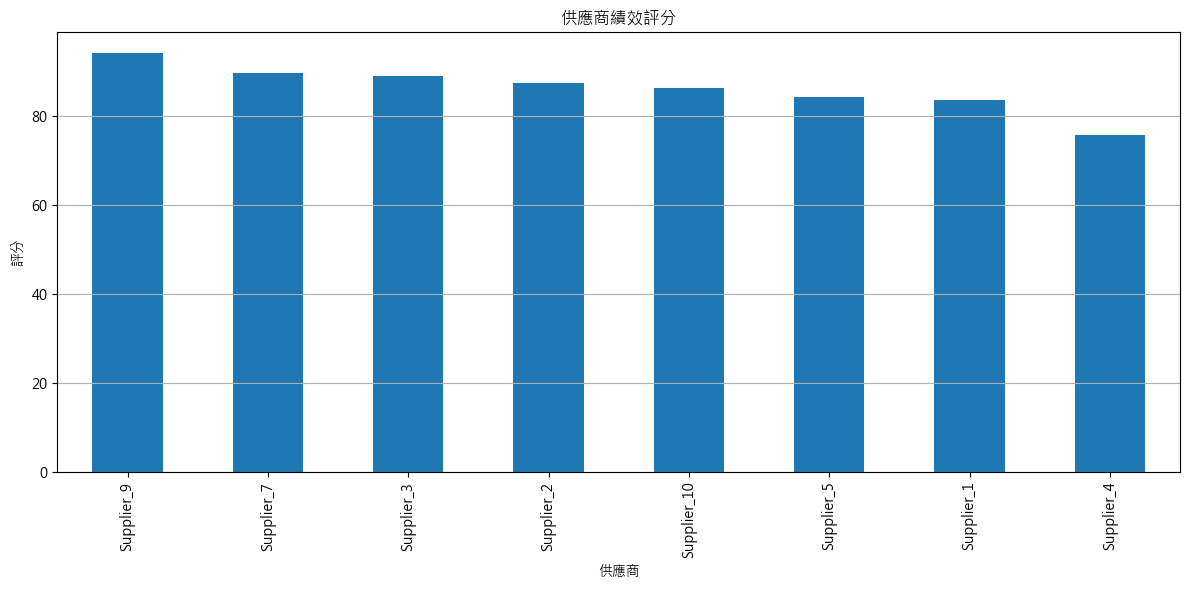

In [150]:
# 供應鏈分析 - 產品供應商績效評估
print("供應鏈分析")

# 創建產品供應時間數據
np.random.seed(42)
order_dates = pd.date_range('2023-01-01', periods=300, freq='D')
product_ids = np.random.choice(products['product_id'].values, 300)
supplier_ids = [products[products['product_id'] == pid]['supplier_id'].values[0] for pid in product_ids]

supply_chain_data = pd.DataFrame({
    'order_date': order_dates,
    'product_id': product_ids,
    'supplier_id': supplier_ids,
    'order_quantity': np.random.randint(10, 100, 300),
    'lead_time_days': np.random.randint(1, 30, 300),  # 供應商供貨天數
    'defect_rate': np.random.uniform(0, 0.05, 300)   # 產品缺陷率
})

# 合併供應商資訊
supply_chain_with_supplier = pd.merge(
    supply_chain_data,
    suppliers,
    on='supplier_id'
)

# 合併產品資訊
supply_chain_full = pd.merge(
    supply_chain_with_supplier,
    products[['product_id', 'product_name', 'category_id']],
    on='product_id'
)

# 合併類別資訊
supply_chain_full = pd.merge(
    supply_chain_full,
    categories,
    on='category_id'
)

print("供應鏈數據:")
print(supply_chain_full.head())

# 供應商績效評估
supplier_performance = supply_chain_full.groupby('supplier_name').agg({
    'lead_time_days_x': ['mean', 'min', 'max', 'std'],
    'defect_rate': ['mean', 'max'],
    'order_quantity': 'sum',
    'product_id': 'nunique'
})


# 降級多級列索引
supplier_performance.columns = ['平均供貨天數', '最短供貨天數', '最長供貨天數', '供貨天數標準差', 
                              '平均缺陷率', '最高缺陷率', '訂購總量', '產品種類數']

# 創建綜合評分
supplier_performance['評分'] = (
    (1 / supplier_performance['平均供貨天數']) * 30 +  # 供貨天數越短越好
    (1 - supplier_performance['平均缺陷率']) * 50 +    # 缺陷率越低越好
    np.log10(supplier_performance['訂購總量']) * 10 +  # 訂購量大但影響較小
    np.log10(supplier_performance['產品種類數']) * 10  # 產品多樣性也考慮
)

# 排序
supplier_performance = supplier_performance.sort_values('評分', ascending=False)

print("\n供應商績效評估:")
print(supplier_performance)

# 可視化供應商評比
plt.figure(figsize=(12, 6))
supplier_performance['評分'].plot(kind='bar')
plt.title('供應商績效評分')
plt.xlabel('供應商')
plt.ylabel('評分')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 7.3 客戶生命週期價值分析

客戶生命週期價值分析
客戶生命週期價值 (CLV) 分析:
    客戶ID         客戶名稱     年度消費  訂單數量   平均訂單金額  預估生命週期價值      客戶細分
91    92  Customer_92  5633.51  5.67  1217.65  28167.54  B - 中高價值
4      5   Customer_5  5389.62  4.67  1100.95  26948.12  B - 中高價值
89    90  Customer_90  5212.52  6.00   845.05  26062.62  B - 中高價值
50    51  Customer_51  5205.17  6.00   810.29  26025.86  B - 中高價值
85    86  Customer_86  4941.04  4.67  1158.53  24705.22  B - 中高價值
62    63  Customer_63  4906.56  5.00  1008.47  24532.79  B - 中高價值
22    23  Customer_23  4872.81  4.00  1323.90  24364.05  B - 中高價值
16    17  Customer_17  4766.56  5.00   897.14  23832.82  B - 中高價值
61    62  Customer_62  4693.56  4.00  1116.82  23467.80  B - 中高價值
0      1   Customer_1  4615.82  5.00   896.67  23079.10  B - 中高價值

客戶細分分析:
       客戶細分  客戶數量      總CLV     平均CLV  客戶佔比   收入佔比
0  B - 中高價值    18  4.23e+05  23517.18  18.0  28.74
1   C - 中價值    80  1.04e+06  13026.26  80.0  70.76
2   D - 低價值     2  7.36e+03   3682.12   2.0   0.50


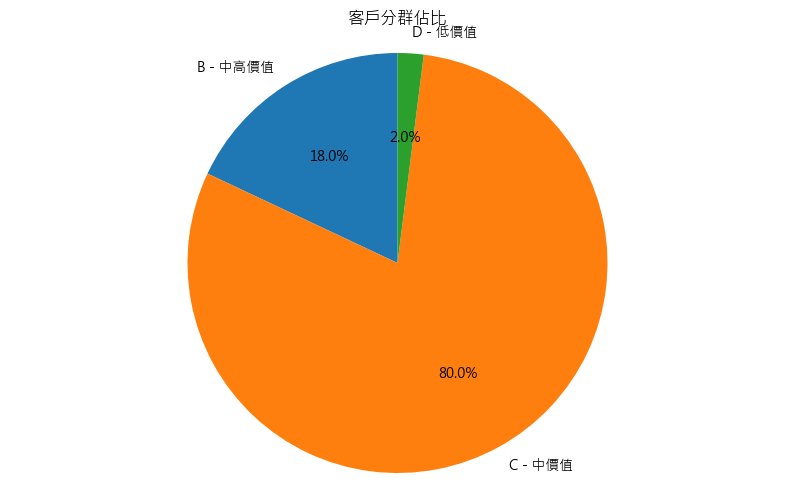

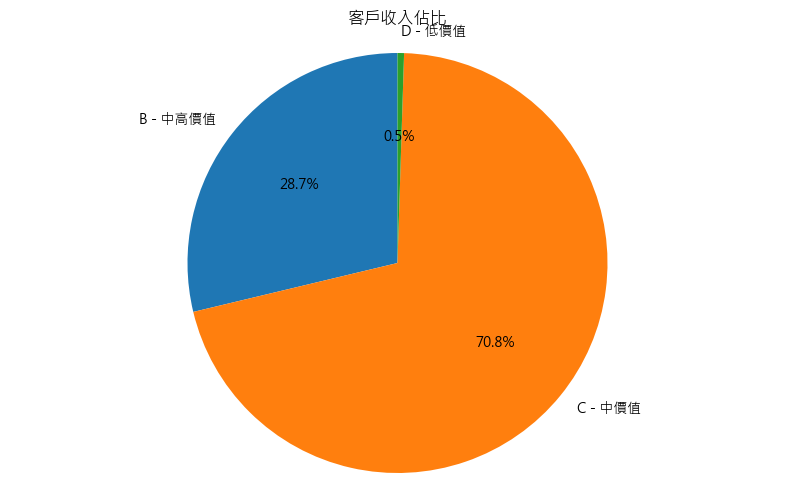

In [153]:
# 客戶生命週期價值分析 (CLV)
print("客戶生命週期價值分析")

# 假設我們已有完整的訂單資料
if 'full_orders' in locals():
    # 添加訂單年份列
    full_orders['order_year'] = full_orders['order_date'].dt.year
    
    # 計算每個客戶每年的消費
    customer_yearly_spending = full_orders.groupby(['customer_id', 'customer_name', 'order_year']).agg({
        'item_price': 'sum',
        'order_id': 'nunique'
    }).reset_index()
    
    customer_yearly_spending.columns = ['客戶ID', '客戶名稱', '年份', '年度消費', '訂單數量']
    
    # 計算平均訂單金額
    customer_yearly_spending['平均訂單金額'] = customer_yearly_spending['年度消費'] / customer_yearly_spending['訂單數量']
    
    # 計算客戶生命週期價值 (簡化版 - 平均年度消費 * 預期客戶年限)
    customer_avg_yearly = customer_yearly_spending.groupby(['客戶ID', '客戶名稱']).agg({
        '年度消費': 'mean',
        '訂單數量': 'mean',
        '平均訂單金額': 'mean'
    }).reset_index()
    
    # 假設平均客戶關係維持5年 (實際應使用更複雜的存活分析)
    expected_years = 5
    customer_avg_yearly['預估生命週期價值'] = customer_avg_yearly['年度消費'] * expected_years
    
    # 對客戶進行細分 (基於CLV)
    def clv_segment(clv):
        if clv >= 50000:
            return 'A - 高價值'
        elif clv >= 20000:
            return 'B - 中高價值'
        elif clv >= 5000:
            return 'C - 中價值'
        else:
            return 'D - 低價值'
    
    customer_avg_yearly['客戶細分'] = customer_avg_yearly['預估生命週期價值'].apply(clv_segment)
    
    # 按照CLV排序
    customer_avg_yearly = customer_avg_yearly.sort_values('預估生命週期價值', ascending=False)
    
    print("客戶生命週期價值 (CLV) 分析:")
    print(customer_avg_yearly.head(10))
    
    # 計算每個細分的客戶數量和總CLV
    segment_analysis = customer_avg_yearly.groupby('客戶細分').agg({
        '客戶ID': 'count',
        '預估生命週期價值': 'sum'
    }).reset_index()
    
    segment_analysis.columns = ['客戶細分', '客戶數量', '總CLV']
    segment_analysis['平均CLV'] = segment_analysis['總CLV'] / segment_analysis['客戶數量']
    segment_analysis['客戶佔比'] = segment_analysis['客戶數量'] / segment_analysis['客戶數量'].sum() * 100
    segment_analysis['收入佔比'] = segment_analysis['總CLV'] / segment_analysis['總CLV'].sum() * 100
    
    print("\n客戶細分分析:")
    print(segment_analysis)
    
    # 繪製客戶細分佔比圖
    plt.figure(figsize=(10, 6))
    plt.pie(segment_analysis['客戶數量'], labels=segment_analysis['客戶細分'], 
            autopct='%1.1f%%', startangle=90)
    plt.title('客戶分群佔比')
    plt.axis('equal')
    plt.show()
    
    # 繪製客戶收入佔比圖
    plt.figure(figsize=(10, 6))
    plt.pie(segment_analysis['總CLV'], labels=segment_analysis['客戶細分'], 
            autopct='%1.1f%%', startangle=90)
    plt.title('客戶收入佔比')
    plt.axis('equal')
    plt.show()
else:
    print("尚未創建完整訂單視圖，請確保執行前面的代碼")


## 📊 8. 合併的最佳實踐與總結

In [154]:
# 整理合併操作的最佳實踐
merge_best_practices = pd.DataFrame({
    '領域': [
        '數據準備', '數據準備', '性能優化', '性能優化', '性能優化',
        '數據驗證', '數據驗證', '高階技巧', '高階技巧', '高階技巧'
    ],
    '最佳實踐': [
        '合併前檢查鍵的分布', '確保合併鍵沒有意外的缺失值', '對大型數據集先排序再合併', 
        '使用分塊策略處理超大數據集', '考慮將字符串類型的鍵轉換為類別(category)型別',
        '驗證合併後的行數是否符合預期', '檢查合併後聚合指標是否保持一致',
        '多表合併時使用逐步合併，檢查每步結果', '使用 merge_asof 處理時間相近但不完全匹配的情況',
        '利用 SQL 處理非常複雜的合併邏輯'
    ],
    '說明': [
        '分析每個合併鍵的唯一值數量和重複情況，避免意外的笛卡爾積',
        '缺失值在合併時的行為可能不如預期，特別是在外部合併時',
        '對排序好的數據進行合併可以顯著提高大型數據集的合併性能',
        '將大型數據集分割成小塊逐個合併，可以減少記憶體使用',
        '對於重複值多的字串鍵，轉換為category可以節省記憶體並加速合併',
        '檢查合併後的數據量是否符合預期，特別是有重複鍵的情況',
        '合併後，確保關鍵的總計、計數等聚合指標保持正確',
        '複雜的多表合併應分步驟執行，每步都檢查結果的正確性',
        '金融、物聯網等領域常需要將事件與最近的參考數據匹配',
        '對於特別複雜的合併邏輯，使用SQL可能更為直觀且高效'
    ]
})

print("合併操作最佳實踐:")
print(merge_best_practices)

合併操作最佳實踐:
     領域                           最佳實踐                                  說明
0  數據準備                      合併前檢查鍵的分布        分析每個合併鍵的唯一值數量和重複情況，避免意外的笛卡爾積
1  數據準備                  確保合併鍵沒有意外的缺失值          缺失值在合併時的行為可能不如預期，特別是在外部合併時
2  性能優化                   對大型數據集先排序再合併         對排序好的數據進行合併可以顯著提高大型數據集的合併性能
3  性能優化                  使用分塊策略處理超大數據集           將大型數據集分割成小塊逐個合併，可以減少記憶體使用
4  性能優化    考慮將字符串類型的鍵轉換為類別(category)型別  對於重複值多的字串鍵，轉換為category可以節省記憶體並加速合併
5  數據驗證                 驗證合併後的行數是否符合預期          檢查合併後的數據量是否符合預期，特別是有重複鍵的情況
6  數據驗證                檢查合併後聚合指標是否保持一致             合併後，確保關鍵的總計、計數等聚合指標保持正確
7  高階技巧             多表合併時使用逐步合併，檢查每步結果           複雜的多表合併應分步驟執行，每步都檢查結果的正確性
8  高階技巧  使用 merge_asof 處理時間相近但不完全匹配的情況           金融、物聯網等領域常需要將事件與最近的參考數據匹配
9  高階技巧             利用 SQL 處理非常複雜的合併邏輯          對於特別複雜的合併邏輯，使用SQL可能更為直觀且高效



**課程總結**：

本課程深入探討了 Pandas 中的進階數據合併與連接技術，涵蓋的關鍵內容包括：

1. **複雜數據關係處理**
   - 多表關聯分析和數據量變化的理解
   - 避免笛卡爾積問題的策略

2. **合併驗證與診斷技術**
   - 驗證合併操作的完整性
   - 合併後數據一致性檢查

3. **高性能合併技術**
   - 大數據集合併優化方法
   - 使用 SQL 處理超大數據集

4. **進階特殊合併技術**
   - 條件式合併
   - 使用 pd.merge_asof 進行近似合併
   - 分層數據的合併

5. **業務智能實際案例**
   - 銷售數據多維分析
   - 供應鏈分析
   - 客戶生命週期價值分析

掌握這些進階技術，能夠幫助數據分析師和數據工程師處理複雜的數據整合任務，提高數據處理的效率和準確性，從而為業務決策提供更全面、更深入的數據支持。